# Homework 2

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Original image

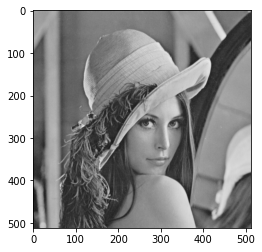

In [2]:
img = cv2.imread('lena.bmp')
plt.imshow(img)
plt.show()

### Binary image

In [3]:
def binarize_at_128(img):
    return (img >= 128) * 255

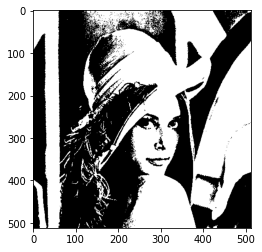

In [4]:
binarize_img = binarize_at_128(img)
plt.imshow(binarize_img)
plt.show()

### Histogram

In [5]:
def generate_histogram(img):
    hist = np.zeros(256, dtype=int)
    
    for img_row in img:
        for pixel in img_row:
            hist[pixel] += 1
    
    return hist

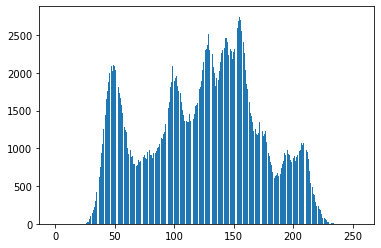

In [6]:
hist = generate_histogram(img)
plt.bar(range(0, 256), hist)
plt.show()

### Connected Components

In [7]:
class DisjointSet:
    def __init__(self):
        self.parent = {}
    
    def find(self, item):
        if self.parent[item] == item:
            return item
        else:
            return self.find(self.parent[item])
    
    def union(self, set1, set2):
        root1 = self.find(set1)
        root2 = self.find(set2)
        self.parent[root1] = root2
    
    def make_set(self, x):
        if x not in self.parent:
            self.parent[x] = x
        else:
            raise ValueError('should not make a exist set')

In [8]:
def two_pass(binary_img):
    current_label = 1
    n_rows, n_cols = binary_img.shape
    processed_img = np.zeros((n_rows+1, n_cols+1), dtype=int)
    link = DisjointSet()
    
    # First pass
    for i in range(n_rows):
        for j in range(n_cols):
            if binary_img[i][j]: # Not background
                
                # Check if neighbor (UP and LEFT) has been labeled
                if processed_img[i][j+1] or processed_img[i+1][j]:
                    if processed_img[i][j+1] and processed_img[i+1][j]: # Both neighbor labeled
                        processed_img[i+1][j+1] = min(processed_img[i][j+1], processed_img[i+1][j])
                        link.union(processed_img[i][j+1], processed_img[i+1][j])
                    
                    else: # Only one neighbor labeled
                        processed_img[i+1][j+1] = max(processed_img[i][j+1], processed_img[i+1][j])
                    
                else:
                    link.make_set(current_label)
                    processed_img[i+1][j+1] = current_label
                    current_label += 1

    # Second pass
    for i in range(n_rows):
        for j in range(n_cols):
            if binary_img[i][j]: # Not background
                processed_img[i+1][j+1] = link.find(processed_img[i+1][j+1])
            
    return processed_img[1:, 1:]

In [9]:
def omit_region(img, threshold):
    labels, counts = np.unique(img, return_counts=True)
    above_threshold = [label for label, count in zip(labels, counts) if count > threshold]
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] in above_threshold:
                img[i][j] = above_threshold.index(img[i][j])
            
            else:
                img[i][j] = 0
                
    return img

In [10]:
def find_connected_component(img, threshold=500):
    binary_img = (img >= 128)[:, :, 0]
    connected_component = two_pass(binary_img)
    connected_component = omit_region(connected_component, threshold)
    
    return connected_component

In [11]:
def get_bounding_box_and_centroid(img):
    n_labels = np.unique(img).shape[0] - 1
    
    positions = [[] for _ in range(n_labels)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > 0:
                positions[img[i][j]-1].append((i, j))
    
    bounding_boxes = [] # top, left, right, bottom
    centroids = [] # row, col
    
    for pos in positions:
        top = min(pos, key=lambda x: x[0])[0]
        left = min(pos, key=lambda x: x[1])[1]
        right = max(pos, key=lambda x: x[1])[1]
        bottom = max(pos, key=lambda x: x[0])[0]
        bounding_boxes.append((top, left, right, bottom))
        
        center_i, center_j = [sum(i) / len(i) for i in zip(*pos)]
        centroids.append((int(center_i), int(center_j)))

    return bounding_boxes, centroids

In [12]:
def draw_connected_component_img(connected_component, img, colors):
    connected_component_img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if connected_component[i][j] > 0:
                connected_component_img[i][j] = colors[connected_component[i][j]-1]
                
    return connected_component_img

In [13]:
def draw_bounding_box(img, bounding_box, color):
    top, left, right, bottom = bounding_box
    cv2.rectangle(img, (left, top), (right, bottom), color, 2)

In [14]:
def draw_centroid(img, centroid, length=10):
    cen_i, cen_j = centroid
    cv2.line(img, (cen_j-length, cen_i), (cen_j+length, cen_i), (255, 255, 255), 2)
    cv2.line(img, (cen_j, cen_i-length), (cen_j, cen_i+length), (255, 255, 255), 2)

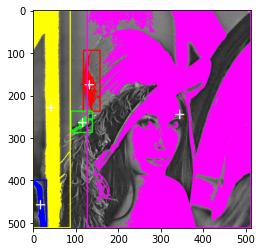

In [15]:
connected_component = find_connected_component(img)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
bounding_boxes, centroids = get_bounding_box_and_centroid(connected_component)
connected_component_img = draw_connected_component_img(connected_component, img, colors)
for bounding_box, centroid, color in zip(bounding_boxes, centroids, colors):
    draw_bounding_box(connected_component_img, bounding_box, color)
    draw_centroid(connected_component_img, centroid)
            
plt.imshow(connected_component_img)
plt.show()